In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

import random
import string
import seaborn as sns
import os
import numpy as np
import timeit

In [2]:
model_logs_root = '/Users/rohan/Documents/python-projects/deepracer/2022-October/Logs-Milestone-Every2-NoCrash-10Hours'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '4'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 350000000.0,
 'term_cond_max_episodes': 1000000000}
-------------
{'speed': {'high': 1.0, 'low': 0.5},
 'steering_angle': {'high': 30.0, 'low': -30.0}}


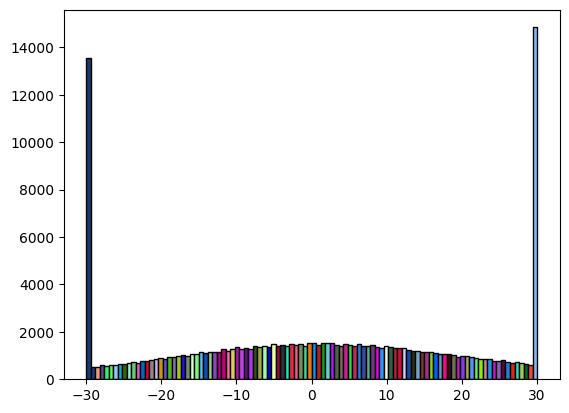

['#163B6E', '#203A74', '#EB9B79', '#5E4597', '#28F66C', '#66F554', '#95C2FE', '#0AACBE', '#2C6514', '#93F4CE', '#77C178', '#E25EC9', '#0667B8', '#DE0032', '#8B8787', '#CDB6E3', '#C69715', '#644FD0', '#50B61F', '#8475AD', '#A7C233', '#270EE2', '#6C906E', '#D3FDCC', '#7AF77D', '#5CBAF4', '#144BAC', '#91D987', '#8A46BD', '#A90877', '#BB076F', '#F36EA2', '#DFC959', '#A918B8', '#C641EC', '#63127D', '#B630F7', '#285508', '#9BA748', '#9DF9B4', '#0308D3', '#F3FF9C', '#911036', '#302F37', '#1CE7AD', '#E62945', '#EE5B8A', '#719059', '#45D395', '#EB7519', '#0693FA', '#AD2522', '#0DA026', '#6ECBCC', '#B514FC', '#4C6341', '#7F6864', '#C6218C', '#2ED93E', '#B82C59', '#247FDA', '#3C479D', '#51B089', '#6F3782', '#E403E1', '#3192FC', '#F7FDE3', '#29624F', '#BD1F2F', '#CC0F3B', '#C0D3FE', '#16469F', '#2B3310', '#769FC3', '#7F362F', '#A0308F', '#7DD917', '#095CFA', '#4BA5CD', '#F60C81', '#2E131B', '#6F6F55', '#C21BB9', '#7D3EE2', '#A3A94C', '#5491FB', '#63ED72', '#88F008', '#C985A1', '#2294DB', '#C21BC9'

In [3]:
# Figure and set of subplots
fig, ax = plt.subplots()

complete_ep = df[df['progress'] == 100]['episode'].to_numpy()[np.newaxis, :]
all_ep = df['episode'].to_numpy()[:, np.newaxis]
complete_rows = np.any(complete_ep == all_ep, axis=1)

# Plot a histogram with random data
N, bins, patches = ax.hist(df[complete_rows]['steering_angle'], bins=100, edgecolor='black', linewidth=1)

# Random facecolor for each bar
colors = []
for i in range(len(N)):
    colors.append("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))
    patches[i].set_facecolor(colors[i])

# Display the plot
plt.show()
print(colors)
print(bins)

<AxesSubplot:xlabel='steering_angle', ylabel='Density'>

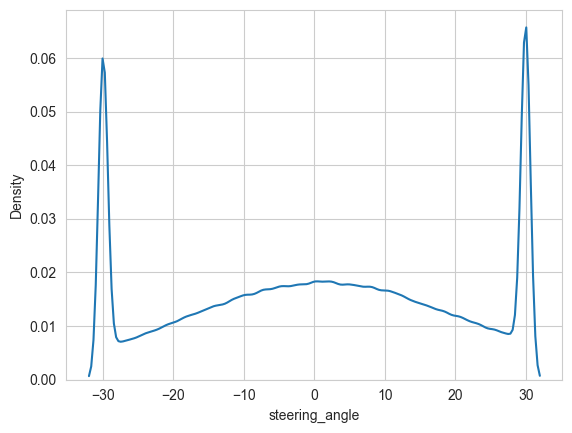

In [4]:
sns.set_style('whitegrid')
sns.kdeplot(df[complete_rows]['steering_angle'], bw=0.035)

In [3]:
track_path = "/Users/rohan/Documents/python-projects/deepracer/deepracer-k1999-race-lines/tracks/"
ListFiles = [f for f in os.listdir(track_path) if os.path.isfile(os.path.join(track_path, f))]
print(ListFiles)

['reInvent2019_track.npy', '2022_august_open.npy', 'Canada_Training.npy', 'canada_race.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'H_track.npy', 'reinvent_base.npy', '2022_september_open.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'China_track.npy', '2022_july_open.npy', '2022_june_open.npy', 'London_Loop_Train.npy']


In [4]:
def get_track_waypoints(track_name):
    return np.load("%s/%s.npy" % (track_path, track_name))

trackname="2022_september_open"
waypoints = get_track_waypoints(trackname)
waypoints.shape

(152, 6)

In [5]:
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [6]:
def plot_track(ax):
    ax.plot(inner_border[:, 0], inner_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(outer_border[:, 0], outer_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(inner_border[:, 0], inner_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    ax.plot(outer_border[:, 0], outer_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [9]:
pd.set_option('display.max_rows', 500)
df[df['progress'] == 100].sort_values('steps')

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
144750,374,745.0,0.068410,1.531901,-141.484355,30.000000,0.659657,-1,0.222469,True,True,100.0,102,43.312331,14274.840,lap_complete,0.0,18,0,374
178128,424,745.0,-2.540818,-3.471020,13.018098,9.647156,0.718385,-1,0.313387,True,True,100.0,29,43.312331,17405.389,lap_complete,0.0,21,0,424
143009,371,752.0,5.668347,3.704808,158.829374,-22.495959,0.649014,-1,0.423803,True,True,100.0,80,43.312331,14158.574,lap_complete,0.0,18,0,371
166830,407,753.0,3.117895,-0.610641,50.246193,-30.000000,0.947548,-1,0.148057,True,True,100.0,50,43.312331,16367.978,lap_complete,0.0,20,0,407
170835,413,755.0,1.446323,3.235252,-153.487436,-1.458013,0.783318,-1,0.313387,True,True,100.0,95,43.312331,16635.401,lap_complete,0.0,20,0,413
148728,380,756.0,-6.965801,0.976507,-109.944306,2.073637,1.000000,-1,0.313387,True,True,100.0,0,43.312331,14853.054,lap_complete,0.0,19,0,380
165078,404,758.0,-2.534776,-3.454092,26.250450,15.085198,0.603820,-1,0.222469,True,True,100.0,29,43.312331,16250.957,lap_complete,0.0,20,0,404
180138,427,759.0,3.125558,-0.573749,31.935009,0.196793,0.792248,-1,0.313387,True,True,100.0,51,43.312331,17539.597,lap_complete,0.0,21,0,427
149488,381,760.0,-7.236037,-1.182241,-81.071862,30.000000,0.617813,-1,0.222469,True,True,100.0,7,43.312331,14903.794,lap_complete,0.0,19,0,381
169918,411,760.0,5.700208,3.793445,170.512638,20.072846,0.500000,-1,0.148057,True,True,100.0,80,43.312331,16574.103,lap_complete,0.0,20,0,411


In [45]:
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

In [146]:
episode_num = 424
custom_df = df
start= custom_df.index[0]

step = 4
radius = np.zeros(len(custom_df))
steering_angle = np.zeros(len(custom_df))
x_coords = np.zeros(len(custom_df))
y_coords = np.zeros(len(custom_df))
idx = 0

for ep in custom_df['episode'].unique():
    prv = np.roll(custom_df.index[custom_df['episode'] == ep], 1) - start
    cur = np.roll(custom_df.index[custom_df['episode'] == ep], 0) - start
    nxt = np.roll(custom_df.index[custom_df['episode'] == ep], -1) - start
    if custom_df.iloc[prv[0]]['progress'] == 100:
        for i in range(step, len(cur) - step, step):
            radius[idx] = min(10, circle_radius(custom_df.iloc[[prv[i - step], cur[i], nxt[i + step]]][['x', 'y']].to_numpy()))
            steering_angle[idx] = custom_df.iloc[cur[i] - step:cur[i] + step + 1]['steering_angle'].mean()
            x_coords[idx] = custom_df.iloc[cur[i]]['x']
            y_coords[idx] = custom_df.iloc[cur[i]]['y']
            idx += 1

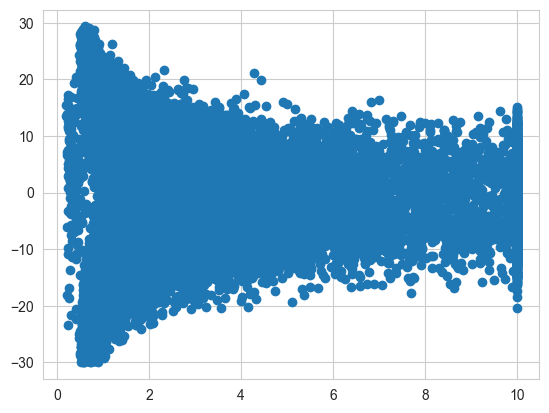

In [147]:
plt.scatter(radius[:idx], steering_angle[:idx])

-30.0
29.359200444454967


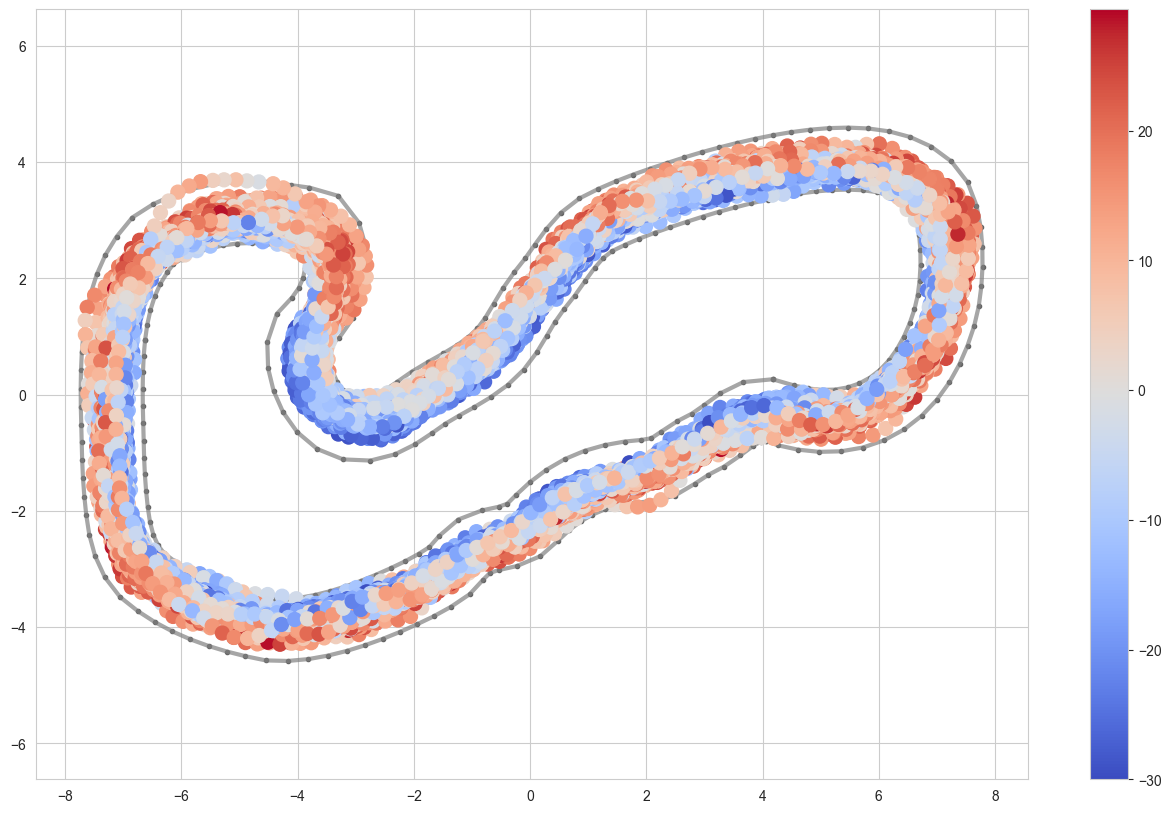

In [148]:
print(steering_angle[:idx].min())
print(steering_angle[:idx].max())

fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    x_coords[:idx], y_coords[:idx], s=100,
    c=steering_angle[:idx], cmap='coolwarm', zorder=3
)
# scatter = ax.scatter(
#     df[df['episode'] == episode_num]['x'], df[df['episode'] == episode_num]['y'], s=100,
#     c=df[df['episode'] == episode_num]['steering_angle'], cmap='coolwarm', zorder=3
# )
fig.colorbar(scatter)

In [7]:
from numpy import array

fname = '../deepracer-k1999-race-lines/steering-angles/2022_september_open-S15-R10-X2.25-Y6-2022-10-23-150503.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
optimal_steering = deserialized
optimal_steering.shape

(151,)

In [8]:
from numpy import array

fname = '../deepracer-k1999-race-lines/racelines/2022_september_open-2000-4-2022-10-23-145109.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
racing_line = deserialized
racing_line.shape

(152, 2)

In [9]:
def plot_racing_line(ax, zdot=1, zline=2):
    ax.plot(racing_line[:, 0], racing_line[:, 1], '.', color='#646464', zorder=zdot)
    ax.plot(racing_line[:, 0], racing_line[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=zline)

In [10]:
npoints = len(racing_line) - 1

In [11]:
def gen_graph_data(episode_num):
    custom_df = df[df['episode'] == episode_num]
    start= custom_df.index[0]

    step = 4
    steering_diff = np.zeros(len(custom_df))
    x_coords = np.zeros(len(custom_df))
    y_coords = np.zeros(len(custom_df))
    idx = 0

    for ep in custom_df['episode'].unique():
        prv = np.roll(custom_df.index[custom_df['episode'] == ep], 1) - start
        cur = np.roll(custom_df.index[custom_df['episode'] == ep], 0) - start
        nxt = np.roll(custom_df.index[custom_df['episode'] == ep], -1) - start
        if custom_df.iloc[prv[0]]['progress'] == 100:
            for i in range(step, len(cur) - step, step):
                coords = custom_df.iloc[cur[i] - step:cur[i] + step + 1][['x', 'y']].to_numpy()
                distances_to_waypoints = np.hypot(racing_line[:npoints, 0:1].T - coords[:, 0:1], racing_line[:npoints, 1:2].T - coords[:, 1:2])
                closest_waypoints = np.argmin(distances_to_waypoints, axis=1)
                steering_angles = custom_df.iloc[cur[i] - step:cur[i] + step + 1]['steering_angle']
                steering_optimals = optimal_steering[closest_waypoints]
                steering_diff[idx] = np.mean(np.abs(steering_angles - steering_optimals))
                x_coords[idx] = custom_df.iloc[cur[i]]['x']
                y_coords[idx] = custom_df.iloc[cur[i]]['y']
                idx += 1
    return idx, steering_diff, x_coords, y_coords

19.938570143832113
15.008765929958757


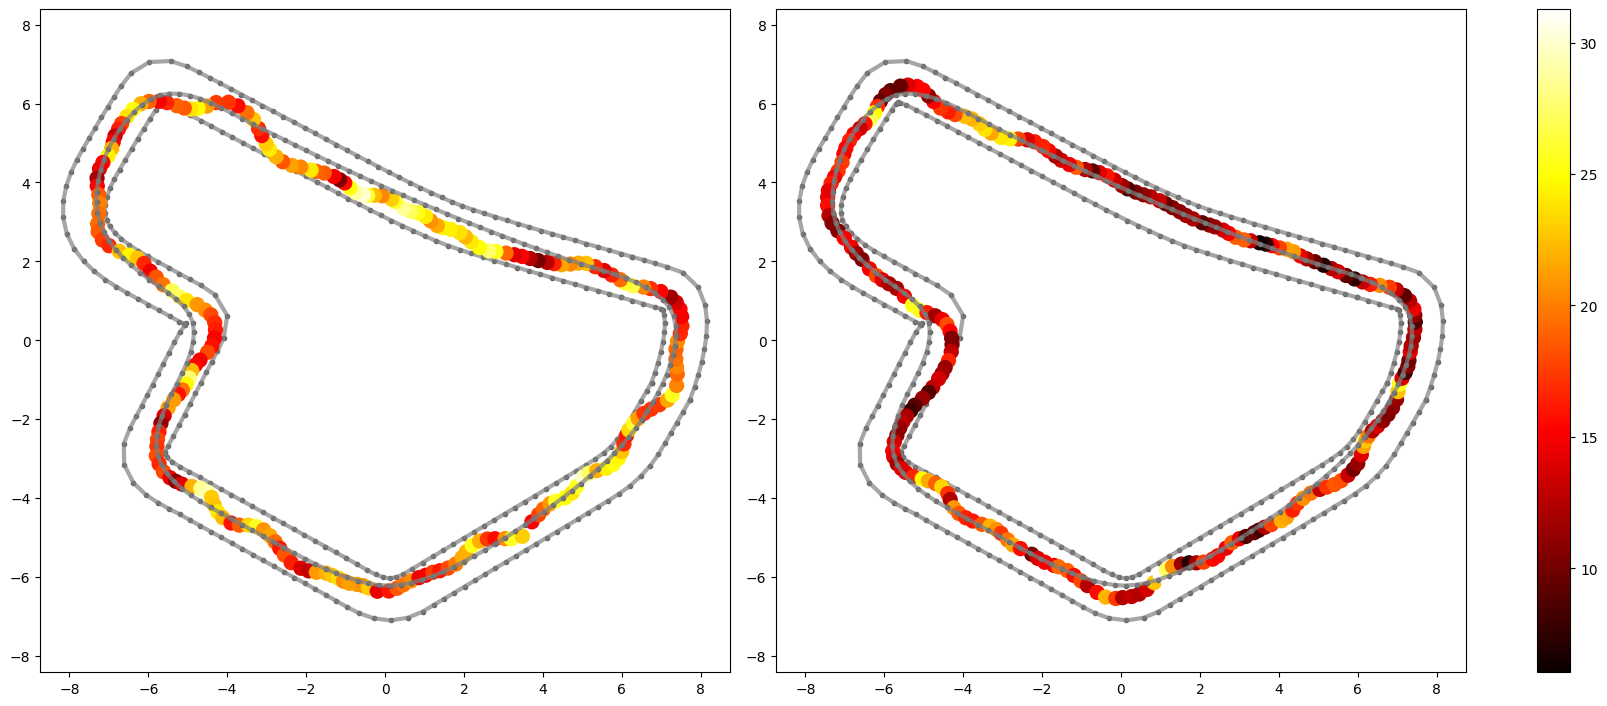

In [12]:
episodes = [236, 473]
idx = [None, None]
steering_diff = [None, None]
x_coords = [None, None]
y_coords = [None, None]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), layout='constrained')
vmin = None
vmax = None

for i in range(axes.size):
    idx[i], steering_diff[i], x_coords[i], y_coords[i] = gen_graph_data(episodes[i])
    vmin = steering_diff[i][:idx[i]].min() if not vmin else min(steering_diff[i][:idx[i]].min(), vmin)
    vmax = steering_diff[i][:idx[i]].max() if not vmax else max(steering_diff[i][:idx[i]].max(), vmax)

for i, ax in enumerate(axes.flat):
    print(steering_diff[i][:idx[i]].mean())
    ax.axis('equal')
    plot_track(ax)
    scatter = ax.scatter(
        x_coords[i][:idx[i]], y_coords[i][:idx[i]], s=100,
        c=steering_diff[i][:idx[i]], cmap='hot', zorder=3,
        vmin=vmin, vmax=vmax
    )
    plot_racing_line(ax, 4, 5)

fig.colorbar(scatter, ax=axes)